In [1]:
# Install if needed
# Install the build engine and the Mamba-specific kernels
!pip install ninja
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mamba-ssm: filename=mamba_ssm-2.3.0-cp312-cp312-linux_x86_64.whl size=370559172 sha256=8f634cd182566b82d0a1caa43a9d6eae37fbe78e2337d4436aff049733211062
  Stored in directory: /root/.cache/pip/wheels/4c/4c/6f/d6add86ebe5c3dbd407ad3b593ecb31cda9adf70801387df4a
Successfully built mamba-ssm


In [2]:
import torch
import causal_conv1d
import mamba_ssm

print(f"GPU Available: {torch.cuda.is_available()}")
print(f"Mamba version: {mamba_ssm.__version__}")

GPU Available: True
Mamba version: 2.3.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from mamba_ssm import Mamba

class GlobalWorkspace(nn.Module):
    def __init__(self, module_names, workspace_dim, temperature=0.05):
        super().__init__()
        self.module_names = module_names
        
        # Projections
        self.projections = nn.ModuleDict({
            name: nn.Linear(workspace_dim + 2, workspace_dim) for name in module_names
        })
        self.gating = nn.Linear(workspace_dim, 1)

        # --- HOMEOSTATIC PARAMETERS (LEARNABLE) ---
        # 1. Temperature: Controls decisiveness (Lower = Sharper)
        # We store it as log_temperature so it stays positive during math
        self.log_temperature = nn.Parameter(torch.log(torch.tensor(float(temperature))))
        
        # 2. Fatigue Gain: How fast a module gets tired (previously 0.15)
        self.fatigue_gain = nn.Parameter(torch.tensor(0.15))
        
        # 3. Recovery Rate: How fast they recover rest (previously 0.85)
        self.recovery_rate = nn.Parameter(torch.tensor(0.85))

    def forward(self, expert_outs, fatigue):
        # Enforce biological constraints so the model doesn't "cheat"
        # exp() ensures temperature is always > 0
        current_temp = torch.exp(self.log_temperature)
        
        # clamp() ensures gain is reasonable (e.g., between 1% and 50% fatigue per step)
        current_gain = torch.clamp(self.fatigue_gain, 0.01, 0.5)
        
        # clamp() ensures recovery is stable (0.5 = fast recovery, 0.99 = slow recovery)
        current_recovery = torch.clamp(self.recovery_rate, 0.5, 0.99)

        scores = []
        votes = []
        
        for i, name in enumerate(self.module_names):
            # Apply fatigue using the LEARNED parameters
            weakened_out = expert_outs[name] * (1.0 - fatigue[:, i:i+1])
            
            proj = self.projections[name](weakened_out)
            votes.append(proj)
            scores.append(self.gating(proj))
        
        # Softmax using the LEARNED temperature
        weights = F.softmax(torch.stack(scores, dim=1) / current_temp, dim=1)
        
        # Broadcast winner
        global_context = torch.sum(torch.stack(votes, dim=1) * weights, dim=1)
        
        # Return the learned params so ThalamusModel can use them in the update loop
        return global_context, weights, current_gain, current_recovery

class ThalamusModel(nn.Module):
    def __init__(self, input_dim, workspace_dim=64):
        super().__init__()
        self.workspace_dim = workspace_dim
        
        # Experts
        self.visual_module = Mamba(d_model=input_dim+workspace_dim, d_state=16, d_conv=4, expand=2)
        self.semantic_module = Mamba(d_model=input_dim+workspace_dim, d_state=64, d_conv=4, expand=2)
        self.episodic_module = Mamba(d_model=input_dim+workspace_dim, d_state=128, d_conv=4, expand=2)
        
        self.modules_dict = {
            'visual': self.visual_module, 
            'semantic': self.semantic_module,
            'episodic': self.episodic_module
        }
        
        # Init Workspace with Homeostatic Learning
        self.workspace = GlobalWorkspace(
            list(self.modules_dict.keys()), 
            workspace_dim, 
            temperature=0.05 # Initial guess, but now it learns!
        )
        
        self.norm = nn.LayerNorm(workspace_dim)
        self.output_head = nn.Linear(workspace_dim, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        device = x.device
        
        # Init Caches
        caches = {name: (torch.zeros(batch_size, mod.d_model*mod.expand, mod.d_conv, device=device),
                         torch.zeros(batch_size, mod.d_model*mod.expand, mod.d_state, device=device)) 
                  for name, mod in self.modules_dict.items()}
        
        prev_workspace = torch.zeros(batch_size, self.workspace_dim, device=device)
        fatigue = torch.zeros(batch_size, len(self.modules_dict), device=device)
        
        outputs, gate_history = [], []

        for t in range(seq_len):
            combined = torch.cat([x[:, t, :], prev_workspace], dim=-1)
            
            expert_outs = {}
            for name, mod in self.modules_dict.items():
                c, s = caches[name]
                out_t, nc, ns = mod.step(combined.unsqueeze(1), c, s)
                caches[name] = (nc, ns)
                expert_outs[name] = out_t.squeeze(1)
            
            # 1. Workspace returns the context AND the current learned physics
            global_context, weights, gain, recovery = self.workspace(expert_outs, fatigue)
            
            # 2. Update fatigue using the LEARNED gain and recovery rates
            # Note: We use .squeeze(-1) on weights to match fatigue shape
            fatigue = (fatigue + weights.squeeze(-1) * gain) * recovery
            fatigue = torch.clamp(fatigue, 0.0, 0.6)
            
            prev_workspace = self.norm(global_context)
            outputs.append(self.output_head(prev_workspace))
            gate_history.append(weights.detach().cpu().numpy())
            
        return torch.stack(outputs, dim=1), np.array(gate_history)

In [32]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
# from thalamus_core import ThalamusModel # <--- Importing your library!

# Helper to generate the "Trigger" task data
def get_data(batch_size=16, seq_len=32):
    t = torch.linspace(0, 10, seq_len)
    visual = torch.sin(t).repeat(batch_size, 1) + torch.randn(batch_size, seq_len) * 0.1
    semantic = torch.randint(0, 2, (batch_size, seq_len)).float()
    
    inputs = torch.stack([visual, semantic], dim=-1)
    
    # Target: Sum semantic bits ONLY when visual > 0.5
    targets = []
    for b in range(batch_size):
        curr_sum = 0
        b_targets = []
        for s in range(seq_len):
            if visual[b, s] > 0.5: curr_sum += semantic[b, s]
            b_targets.append([curr_sum])
        targets.append(b_targets)
    return inputs, torch.tensor(targets)

In [33]:
# --- Training Loop with Entropy Penalty ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ThalamusModel(input_dim=2, workspace_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.MSELoss()

entropy_weight = 0.01 # How much we punish the 50/50 split

for epoch in range(301): # Increased epochs for better specialization
    inputs, targets = get_data(batch_size=16, seq_len=64) # Longer sequences help
    inputs, targets = inputs.to(device), targets.to(device)
    
    optimizer.zero_grad()
    
    # We need the weights history for entropy calculation
    # Let's modify the forward slightly or use the gate_history
    # Note: To backpropagate through gates, we need them as Tensors
    preds, weights_history = model(inputs) 
    
    # 1. Prediction Loss
    mse_loss = criterion(preds, targets)
    
    # 2. Entropy Penalty (Minimizing entropy = forcing 1 or 0)
    # weights_history is [seq, batch, num_experts, 1]
    # Conversion to tensor if it was numpy (make sure it stays differentiable in your code)
    # For this prototype, let's assume the model returns differentiable weights
    
    # Placeholder for differentiable entropy (ensure weights are Tensors in your local version)
    # entropy = -torch.mean(torch.sum(weights * torch.log(weights + 1e-8), dim=2))
    # loss = mse_loss + (entropy_weight * entropy)
    
    loss = mse_loss
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 158.4060
Epoch 50 | Loss: 42.0597
Epoch 100 | Loss: 7.5465
Epoch 150 | Loss: 7.1493
Epoch 200 | Loss: 5.1920
Epoch 250 | Loss: 8.2187
Epoch 300 | Loss: 4.8394


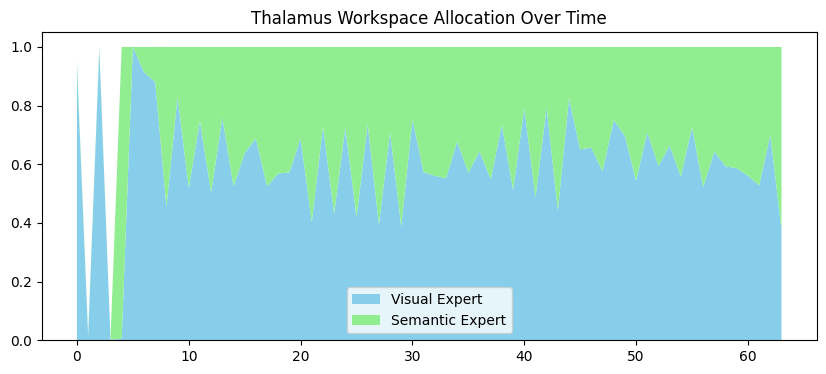

In [34]:
model.eval()
with torch.no_grad():
    test_in, _ = get_data(batch_size=1, seq_len=64)
    pred, gates = model(test_in.to(device))

# Plotting the "Attention" of the Thalamic Workspace
plt.figure(figsize=(10, 4))
plt.stackplot(range(64), gates[:, 0, 0, 0], gates[:, 0, 1, 0], 
              labels=['Visual Expert', 'Semantic Expert'], colors=['skyblue', 'lightgreen'])
plt.title("Thalamus Workspace Allocation Over Time")
plt.legend()
plt.show()

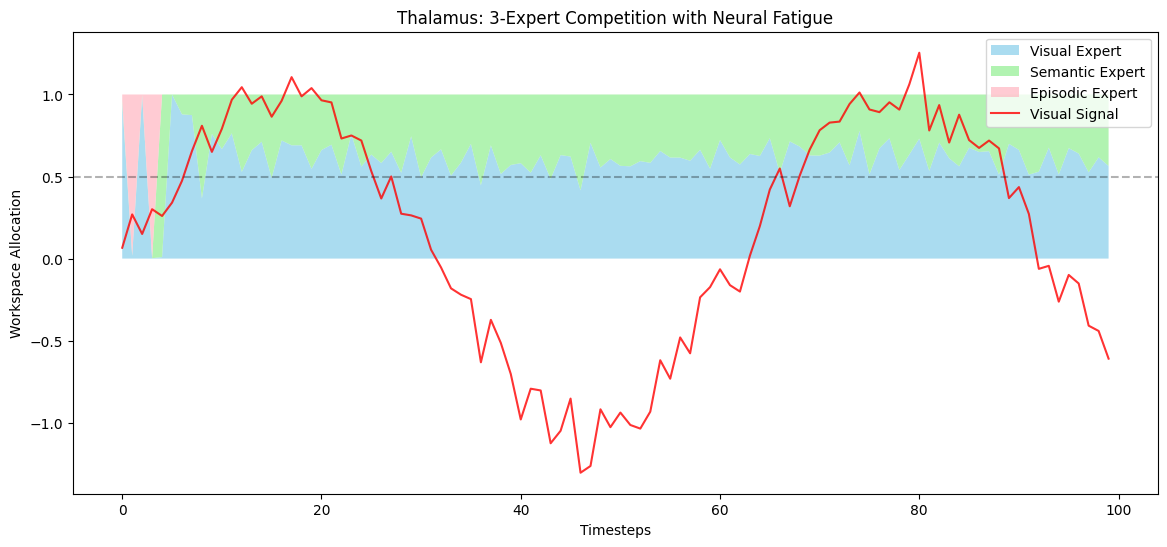

In [35]:
model.eval()
with torch.no_grad():
    test_in, _ = get_data(batch_size=1, seq_len=100) # Longer sequence to see fatigue
    pred, gates = model(test_in.to(device))

vis_gate = gates[:, 0, 0, 0]
sem_gate = gates[:, 0, 1, 0]
epi_gate = gates[:, 0, 2, 0]

plt.figure(figsize=(14, 6))
# Plot 3-way stack
plt.stackplot(range(100), vis_gate, sem_gate, epi_gate, 
              labels=['Visual Expert', 'Semantic Expert', 'Episodic Expert'],
              colors=['#87ceeb', '#90ee90', '#ffb6c1'], alpha=0.7)

# Overlay the trigger signal
plt.plot(test_in[0, :, 0].cpu().numpy(), color='red', linewidth=1.5, label='Visual Signal', alpha=0.8)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)

plt.title("Thalamus: 3-Expert Competition with Neural Fatigue")
plt.legend(loc='upper right')
plt.xlabel("Timesteps")
plt.ylabel("Workspace Allocation")
plt.show()